In [1]:
import numpy as np
import gym
from gym import spaces
import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class EpistasisEnv(gym.Env):
    
#metadata = {'render.modes': ['human']}
    def __init__(self):
        self.SAMPLE_SIZE_CASE = 300 
        self.SAMPLE_SIZE_CONTROL = 300
        filename = "./epigen/sim/0_2_ASW.json"

        def establish_phen_gen(self, file):
            with open(file) as f:
                data = json.load(f)
                genotype = np.array(data["genotype"])
                self.phenotype = np.array(data["phenotype"])
                self.genotype = genotype.T
                num_phenotypes = max(self.phenotype)+1
                self.disease_snps = data["disease_snps"]
                self.phen_gen = [[] for _ in range(num_phenotypes)]
                for i in range(len(self.genotype)):
                    self.phen_gen[self.phenotype[i]].append(i)  
                return  self.genotype.shape[0], self.genotype.shape[1]

#     super(EpistasisEnv, self).__init__()

        self.N_IDV, self.N_SNPS = establish_phen_gen(self, filename)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.N_SNPS,))
        self.observation_space = spaces.Box(low=0, high=2, shape=
                        (self.SAMPLE_SIZE_CASE+self.SAMPLE_SIZE_CONTROL, self.N_SNPS), dtype=np.uint8)
        self.obs_phenotypes = None
        self.obs = None

    
    def step(self, action):
        snp_ids = self._take_action(action)
        reward = self._count_reward(snp_ids) 
        self.current_step += 1

        done = self.current_step == 5
        obs = self._next_observation()
        return obs, reward, done, {}
    def _count_reward(self, snp_ids):
    
        all_existing_seq = defaultdict(lambda: {'control' : 0, 'case' : 0})
        

        for i, idv in enumerate(self.obs):
            snp_to_cmp = tuple(idv[snp_id] for snp_id in snp_ids) #tuple of SNP that 
            if self.obs_phenotypes[i] == 0:
                all_existing_seq[snp_to_cmp]['control'] += 1
            else:
                all_existing_seq[snp_to_cmp]['case'] += 1

        ###count reward      
        TP = 0 #HR case
        FP = 0 #HR control
        TN = 0 #LR control
        FN = 0 #LR case

        for case_control_count in all_existing_seq.values():
#             teta = (self.SAMPLE_SIZE_CONTROL / self.SAMPLE_SIZE_CASE) * (case_control_count['case'] / case_control_count['control'])
            # seq is in LR group
            if self.SAMPLE_SIZE_CONTROL*case_control_count['case'] < self.SAMPLE_SIZE_CASE*case_control_count['control'] :
                FN += case_control_count['case']
                TN += case_control_count['control']
            else:
          # seq is in HR group
                TP += case_control_count['case']
                FP += case_control_count['control']
        R = (FP + TN) / (TP + FN)
        delta = FP / TP
        gamma = (TP + FP + TN + FN) / TP
        CCR = 0.5 * (TP / (TP + FN) + TN / (FP + TN))
#         if ((1 + delta) * (gamma - delta - 1)) == 0:
#             print("delta:",delta,"gamma:", gamma)
        U = (R - delta)**2 / ((1 + delta) * (gamma - delta - 1 + 0.001 ))

        return CCR+U

  
    def reset(self):
        self.current_step = 0
        self.obs = self._next_observation()
        return self.obs

    def render(self, mode='human', close=False):
        pass
    
    def _take_action(self, action):
        chosen_snp_ids = []
        for i, choice in enumerate(action):
            if choice == 1:
                chosen_snp_ids.append(i)
        return chosen_snp_ids    
    def _next_observation(self):

        id_0 = np.random.choice(self.phen_gen[0], self.SAMPLE_SIZE_CONTROL, replace=False)
        id_1 = np.random.choice(self.phen_gen[1], self.SAMPLE_SIZE_CASE, replace=False)
        sample_ids = np.random.choice(np.concatenate([id_0, id_1]), self.SAMPLE_SIZE_CONTROL+self.SAMPLE_SIZE_CASE, replace=False)
        self.obs = np.array([self.genotype[idv] for idv in sample_ids])
        self.obs_phenotypes = [self.phenotype[idv] for idv in sample_ids]

        return self.obs

In [7]:
env = EpistasisEnv()
env.reset()

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 2, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 2, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 1, 0, 0]])

In [8]:
# env.action_space.sample()
snp_ids=[0, 3, 4, 5, 8, 11, 12, 15, 16, 19, 21, 22, 27, 28, 29, 32, 34, 35, 37, 39, 40, 42, 43, 45, 47, 48, 50, 52, 53, 54, 57, 60, 61, 64, 68, 74, 76, 78, 79, 84, 86, 87, 89, 92, 96, 99]
env._count_reward(snp_ids)

1.9990009990009991

In [9]:
env._count_reward([0,1])

0.9785879789030052

In [10]:
len(env.obs_phenotypes)

600

In [11]:
env.N_SNPS

100

env.disease_snps

## Смотрим как выглядят rewards для всех возможных пар снипов

0 10 20 30 40 60 70 80 90 

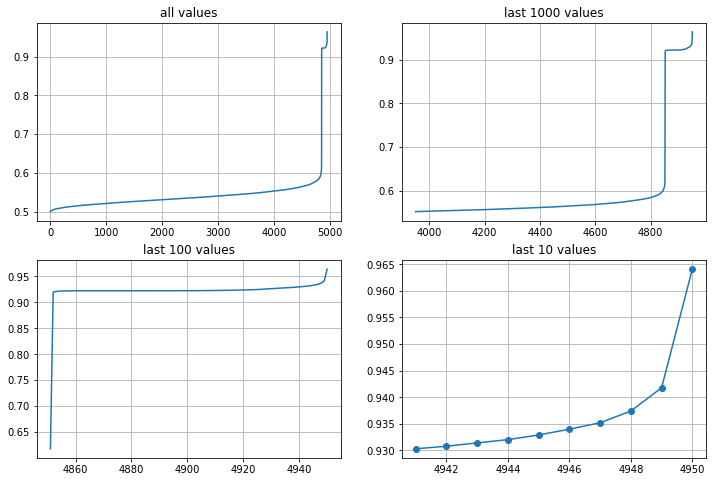

In [10]:
env = EpistasisEnv()
N_rewards = 4950
N_runs = 100
sorted_rewards_list = np.zeros(N_rewards)
for i in range(N_runs):
    if i % 10 == 0:
        print(i, end=' ')
    obs = env.reset()
    rewards = {}
    for i in range(env.N_SNPS):
        for j in range(env.N_SNPS):
            if (i == j):
                continue
            new = env._count_reward([i,j])
            rewards[frozenset((i,j))] = new
    sorted_rewards_list += np.array(sorted(rewards.values()))
    
sorted_rewards_list /=  N_runs


figure, axis = plt.subplots(2, 2, figsize=(12,8))
N = N_rewards

axis[0, 0].plot(range(1, N+1), sorted_rewards_list)
axis[0, 0].set_title("all values")
axis[0, 0].grid(True)

last=1000
axis[0, 1].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:])
axis[0, 1].set_title(f"last {last} values")
axis[0, 1].grid(True)

last=100
axis[1, 0].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:])
axis[1, 0].set_title(f"last {last} values")
axis[1, 0].grid(True)

last=10
axis[1, 1].plot(range(N-last+1, N+1), list(sorted_rewards_list)[-last:], 'o-')
axis[1, 1].set_title(f"last {last} values")
axis[1, 1].grid(True)
  
# Combine all the operations and display
plt.savefig(f"fig_average_{N_runs}.pdf")
plt.show()

In [31]:
rewards = {}
vl = 0
minval = 2
for i in range(100):
    for j in range(100):
        if (i == j):
            continue
        try:
            new = env._count_reward([i,j])
#             print(i,j)
            rewards[frozenset((i,j))] = new
            if new < 0:
                print("new<0", new, i, j)
            if new > vl:
                vl = new
                ij = (i, j)
            if new < minval:
                minval = new
                ijmin = (i,j)
        except ZeroDivisionError:
              print("ZeroDivisionError", i, j)
print(vl, ij)
print(minval, ijmin)

delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
delta: 1.0 gamma: 2.0
1.0047966247215971 (0, 1)
0.5 (23, 30)


In [32]:
len(rewards)

4950

In [33]:
sorted_rewards = {k: v for k, v in sorted(rewards.items(), key=lambda item: item[1])}

In [34]:
list(sorted_rewards.values())[-100:]

[0.617127687914761,
 0.974559703649596,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9766127483118671,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.9773497186668793,
 0.977349718666

/home/tskhakharova/.conda/envs/gen_env/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


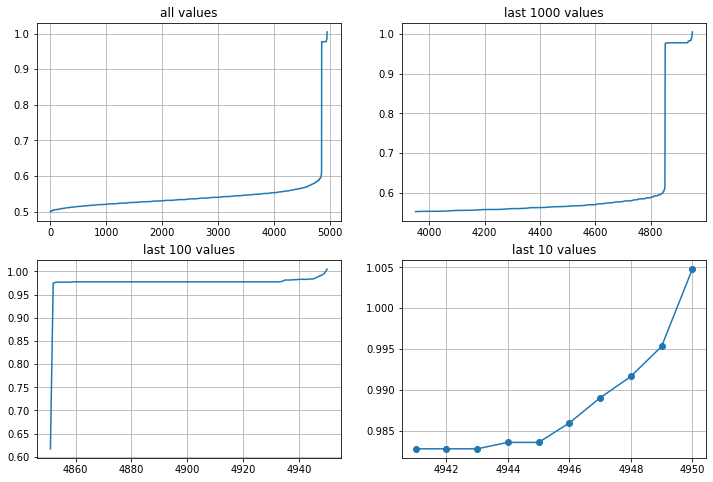

In [35]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(7,5))
# plt.plot(list(sorted_rewards.values())[-10:])
# plt.grid(True)

figure, axis = plt.subplots(2, 2, figsize=(12,8))
N = len(sorted_rewards)

axis[0, 0].plot(range(1, N+1), sorted_rewards.values())
axis[0, 0].set_title("all values")
axis[0, 0].grid(True)

last=1000
axis[0, 1].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:])
axis[0, 1].set_title(f"last {last} values")
axis[0, 1].grid(True)

last=100
axis[1, 0].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:])
axis[1, 0].set_title(f"last {last} values")
axis[1, 0].grid(True)

last=10
axis[1, 1].plot(range(N-last+1, N+1), list(sorted_rewards.values())[-last:], 'o-')
axis[1, 1].set_title(f"last {last} values")
axis[1, 1].grid(True)
  
# Combine all the operations and display
plt.savefig(f"fig_average_{N_runs}.pdf")
plt.show()


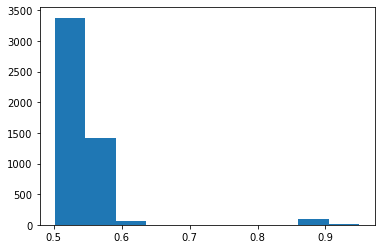

In [30]:
fig, ax = plt.subplots()


In [14]:
env._count_reward([0,1])

0.923156568820646

In [7]:
a = [1,1,1]
n = [2,2]
np.random.choice(np.concatenate([a,n]), 5, replace=False)

array([1, 2, 1, 2, 1])

## Эксперимент с 3 снипами

In [5]:
env = EpistasisEnv()
env.reset()
print(env._count_reward([0,1]))
print(env._count_reward([0,1,2]))
print(env._count_reward([0,1,2,3]))
print(env._count_reward([0,1,2,3,4]))
print(env._count_reward([0,1,2,3,4,5]))
print("----")
print(env._count_reward([2,1,]))
print(env._count_reward([1,2,3]))
print(env._count_reward([1,2,3,4]))
print(env._count_reward([1,2,3,4,5]))

0.8952808832982517
0.8947190996803183
0.9013741875043226
0.9033121193542831
0.9275336181037996
----
0.8530255697462015
0.8586757995882955
0.8599047831184818
0.8854873536009097


In [20]:
n = 1000
env = EpistasisEnv()
env.reset()
rewards = []
for i in range(n):
    snps = list(np.random.randint(low=0, high=100, size=3))
    rewards.append((env._count_reward(snps), snps))

In [18]:
sorted(rewards, key=lambda x:x[0])

[(0.5073809243208302, [89, 30, 35]),
 (0.5102170944236, [85, 16, 30]),
 (0.5109248089242007, [4, 4, 98]),
 (0.5122108368855989, [24, 30, 24]),
 (0.5122118793218001, [18, 54, 3]),
 (0.5122837089151969, [75, 33, 75]),
 (0.5125103974465011, [4, 30, 83]),
 (0.5130386976581027, [3, 30, 18]),
 (0.5140472009251724, [44, 22, 44]),
 (0.5140495163410992, [3, 48, 54]),
 (0.5141078914799821, [94, 75, 36]),
 (0.5147025926068557, [98, 85, 44]),
 (0.515900004940027, [33, 74, 24]),
 (0.5161270103046309, [99, 44, 58]),
 (0.5174634186137431, [30, 22, 47]),
 (0.5177790271811076, [30, 44, 70]),
 (0.5185442662502301, [70, 88, 33]),
 (0.5187279473882007, [86, 30, 9]),
 (0.5187688810383795, [67, 58, 67]),
 (0.5197563628264663, [48, 41, 85]),
 (0.5199185813350987, [54, 70, 33]),
 (0.5200727340721157, [10, 74, 53]),
 (0.5216130521006868, [30, 67, 93]),
 (0.5216177317782738, [68, 35, 85]),
 (0.5216278573418175, [24, 24, 84]),
 (0.5216915737191938, [0, 11, 94]),
 (0.5218086637253273, [86, 94, 61]),
 (0.521967346